In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-a4/train_file.json
/kaggle/input/nlp-a4/val_file.json


In [1]:
# Importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import json
import math
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# Mapping each emotion in the dataset to an integer index
emotion_to_index = {
    'neutral': 0,
    'joy': 1,
    'sadness': 2,
    'fear': 3,
    'anger': 4,
    'surprise': 5,
    'disgust': 6
}

In [5]:
# Training and validation file paths
train_path = '/kaggle/input/nlp-a4/train_file.json'
val_path = '/kaggle/input/nlp-a4/val_file.json'

In [3]:
# Setting cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class FlipDatasetNew(Dataset):
    def __init__(self, path, tokenizer, max_length=50, max_utterances=10, subset_ratio=None):
        with open(path, 'r') as file:
            self.data = json.load(file)

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_utterances = max_utterances
        self.subset_ratio = subset_ratio
        self.positional_embeddings = self.get_sinusoidal_embeddings(1, 50)

    def __len__(self):
        return int(len(self.data) * self.subset_ratio) if self.subset_ratio else len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Emotions
        emotions = [emotion_to_index[emotion] for emotion in item['emotions']]

        # Utterances
        utterances = [self.tokenizer(utterance, max_length=self.max_length - 1, padding='max_length',
                                truncation=True, return_tensors='pt') for utterance in item['utterances']]

        # Stacking utterance
        utterances_id = torch.stack([
            torch.cat((
                torch.tensor([emotions[idx]]),
                utterance['input_ids'].squeeze(0)
            ), dim=0) + self.positional_embeddings[idx][0]
            for idx, utterance in enumerate(utterances)
        ])

        # utterances_id = torch.stack([
        #     torch.cat((
        #         torch.tensor([emotions[idx]]),
        #         utterance['input_ids'].squeeze(0)
        #     ), dim=0)
        #     for idx, utterance in enumerate(utterances)
        # ])

        # Padding or trimming the utterances to max_utterances
        if utterances_id.size(0) >= self.max_utterances:
            utterances_id = utterances_id[utterances_id.size(0) - self.max_utterances:]
        elif utterances_id.size(0) < self.max_utterances:
            utterances_id = torch.cat((
                utterances_id,
                torch.zeros(self.max_utterances - utterances_id.size(0), self.max_length).long()
            ), dim=0)

        # Stacking attention masks
        attention_masks = torch.stack([
            torch.cat((
                torch.tensor([1]),  # Add 1 to indicate the start of a new sequence
                utterance['attention_mask'].squeeze(0)
            ), dim=0) for utterance in utterances
        ])

        # Padding or trimming the attention masks to max_utterances
        if attention_masks.size(0) >= self.max_utterances:
            attention_masks = attention_masks[attention_masks.size(0) - self.max_utterances:]
        elif attention_masks.size(0) < self.max_utterances:
            attention_masks = torch.cat((
                attention_masks,
                torch.zeros(self.max_utterances - attention_masks.size(0), self.max_length).long()
            ), dim=0)

        # Convert attention_masks to boolean
        attention_masks = attention_masks.bool()

        # # Flatten the utterances and attention masks
        # utterances_id = utterances_id.flatten()
        # attention_masks = attention_masks.flatten()

        # Triggers
        try:
            triggers = item['triggers']
            triggers = torch.tensor(triggers)
            if triggers.size(0) >= self.max_utterances:
                triggers = triggers[triggers.size(0) - self.max_utterances:]
            elif triggers.size(0) < self.max_utterances:
                triggers = torch.cat((
                    triggers,
                    torch.zeros(self.max_utterances - triggers.size(0)).long()
                ), dim=0)
                # triggers += [0] * (self.max_utterances - triggers.size(0))
        except RuntimeError:
            triggers = torch.zeros(self.max_utterances).long()

        return {
            'utterances': utterances_id,
            'attention_masks': attention_masks,
            'triggers': triggers
        }

    def get_sinusoidal_embeddings(self, d_model, max_len):
        """
        Generates sinusoidal positional embeddings.

        Args:
        - d_model (int): The dimensionality of the embeddings.
        - max_len (int): The maximum length of the sequence.

        Returns:
        - torch.Tensor: A tensor of shape [max_len, d_model] containing sinusoidal positional embeddings.
        """
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

In [6]:
# Dataloaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = FlipDatasetNew(train_path, tokenizer, max_length=50, max_utterances=10, subset_ratio=0.5)
val_dataset = FlipDatasetNew(val_path, tokenizer, max_length=50, max_utterances=10)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
class EmotionFlipCNN(nn.Module):
    def __init__(self, dropout=0.2):
        super(EmotionFlipCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.ReLU1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.ReLU2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(12288, 128)
        self.ReLU3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 80)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        x = self.pool2(x)
        x = x.flatten()
        # print(x.shape)
        x = self.fc1(x)
        x = self.ReLU3(x)
        x = self.fc2(x)
        return x

In [8]:
# Initializing the model
model = EmotionFlipCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [10]:
# Training the model
num_epochs = 10
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
        if i == len(train_loader) - 1:
            break
        utterances = data['utterances'].to(device)
        masks = data['attention_masks'].to(device)
        triggers = data['triggers'].to(device)

        optimizer.zero_grad()
        outputs = model(utterances)
        # print(outputs.shape, triggers.shape)
        triggers = triggers.flatten()
        loss = criterion(outputs, triggers)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(tqdm(val_loader)):
            if i == len(val_loader) - 1:
                break
            utterances = data['utterances'].to(device)
            masks = data['attention_masks'].to(device)
            triggers = data['triggers'].to(device)
            triggers = triggers.flatten()

            outputs = model(utterances)
            # outputs = outputs.squeeze(dim=1)
            loss = criterion(outputs, triggers)
            val_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))
    validation_losses.append(val_loss / len(val_loader))

    print('Epoch {}:\n\tTraining Loss: {}\n\tValidation Loss: {}'.format(
        epoch + 1, running_loss / len(train_loader), val_loss / len(val_loader)))

 99%|█████████▉| 105/106 [00:04<00:00, 25.11it/s]


Epoch 1:
	Training Loss: 3713.5408090889737
	Validation Loss: 2561.7339782714844


 99%|█████████▉| 105/106 [00:04<00:00, 25.06it/s]


Epoch 2:
	Training Loss: 2330.148411032148
	Validation Loss: 1863.0249679853332


 99%|█████████▉| 105/106 [00:04<00:00, 24.55it/s]


Epoch 3:
	Training Loss: 1681.6692904793256
	Validation Loss: 1286.7685477778596


 99%|█████████▉| 105/106 [00:04<00:00, 24.66it/s]


Epoch 4:
	Training Loss: 1102.7448048523818
	Validation Loss: 750.3135625011516


 99%|█████████▉| 105/106 [00:04<00:00, 24.88it/s]


Epoch 5:
	Training Loss: 645.6390302305538
	Validation Loss: 421.1953838276413


 99%|█████████▉| 105/106 [00:04<00:00, 25.04it/s]


Epoch 6:
	Training Loss: 353.3235087778896
	Validation Loss: 231.78127198849083


 99%|█████████▉| 105/106 [00:04<00:00, 25.24it/s]


Epoch 7:
	Training Loss: 200.7782718061836
	Validation Loss: 147.9396400091783


 99%|█████████▉| 105/106 [00:04<00:00, 25.17it/s]


Epoch 8:
	Training Loss: 123.22908697535077
	Validation Loss: 113.56822560868173


 99%|█████████▉| 105/106 [00:04<00:00, 24.87it/s]


Epoch 9:
	Training Loss: 102.44089758452645
	Validation Loss: 92.90189721449366


 99%|█████████▉| 105/106 [00:04<00:00, 23.93it/s]

Epoch 10:
	Training Loss: 86.3948452800371
	Validation Loss: 82.34686412451403


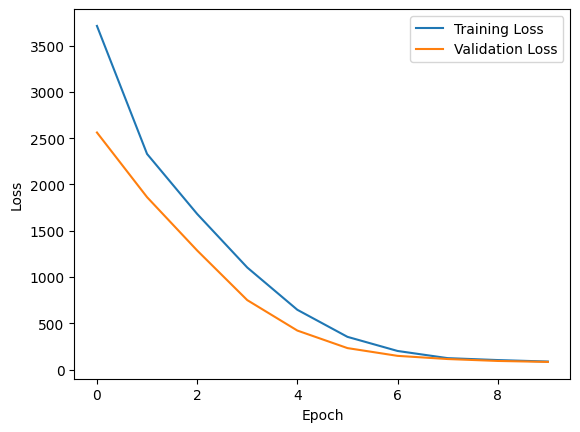

In [11]:
# Graphing the losses
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Saving the model after sending it to cpu
model.to('cpu')
torch.save(model.state_dict(), 'm4.pth')

In [9]:
# Loading the model
model = EmotionFlipCNN()
model.load_state_dict(torch.load('m4.pth'))
model.to(device)

EmotionFlipCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (ReLU3): ReLU()
  (fc2): Linear(in_features=128, out_features=80, bias=True)
)

In [14]:
model.to(device)

EmotionFlipCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (ReLU3): ReLU()
  (fc2): Linear(in_features=128, out_features=80, bias=True)
)

In [15]:
# FInd f1 score
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader)):
        if i == len(val_loader) - 1:
            break
        utterances = data['utterances'].to(device)
        masks = data['attention_masks'].to(device)
        triggers = data['triggers'].to(device)

        triggers = triggers.flatten()

        outputs = model(utterances)
        outputs = (outputs >= 0.5).float()
        y_true.extend(triggers.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 Score: {}'.format(f1))

 99%|█████████▉| 105/106 [00:04<00:00, 24.42it/s]

F1 Score: 0.7623529196166777


In [16]:
# Find accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(tqdm(train_loader)):
        if i == len(train_loader) - 1:
            break
        utterances = data['utterances'].to(device)
        masks = data['attention_masks'].to(device)
        triggers = data['triggers'].to(device)

        triggers = triggers.flatten()

        outputs = model(utterances)
        outputs = (outputs >= 0.5).float()
        correct += (outputs == triggers).sum().item()
        total += triggers.size(0)

accuracy = correct / total
print('Accuracy: {}'.format(accuracy))


100%|█████████▉| 421/422 [00:17<00:00, 24.63it/s]

Accuracy: 0.7526722090261283
